# OpenAI Gymを用いた強化学習 for SageMaker Studio Lab

# 前準備

### モジュールインストール
Open AI Gymとkeras-rl2をインストールします。

In [1]:
%pip install gym
%pip install keras-rl2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 学習開始!

## 必要なモジュールをimport

In [2]:
import gym
from gym import wrappers
from numpy.lib.function_base import average
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [3]:
import tensorflow as tf
tf.__version__

'2.7.0'

## 学習時のコールバック関数
* 学習結果をplotするために、各ステップの情報を記憶するCallbackを実装します。
* 学習そのものには必要ありません。今回はエピソードごとの報酬をグラフにしています。

In [4]:
import rl.callbacks
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.rewards = {}

    def on_episode_begin(self, episode, logs):
        self.rewards[episode] = 0.0
 
    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.rewards[episode] = self.rewards[episode] + logs['reward']
cb_ep = EpisodeLogger()

## パラメーター

In [5]:
limit_steps =  100000
nb_episodes = 5
env_name = 'MountainCar-v0'
notebook_root = "/home/studio-lab-user"

#ファイルやモデルの保存場所
title_name = f"{notebook_root}/{env_name}_{str(limit_steps)}"
model_path = f"{notebook_root}/{env_name}/model/"

In [6]:
import os
os.makedirs(model_path,exist_ok=True)

## 環境の作成

In [7]:
env = gym.make(env_name)
nb_actions = env.action_space.n #有効なaction数

## モデルの定義
* OpenAI Gymのサンプルにある簡単なニューラルネットワークを作りました。

### IN
車の速度、車の場所

### OUT
車のアクション
左、何もしない、右

In [8]:
# モデルの定義
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 16)                48        
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)                0

## 学習環境の作成
* ポリシーの指定
 * epsilon-greedy を指定。
 * Keras-RLには他にもポリシーがあります。
   * LinearAnnealedPolicy, SoftmaxPolicy, EpsGreedyQPolicy, GreedyQPolicy, BoltzmannQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy
* 学習の設定
 * DQN(Deep Q-Network)を採用、オプションでDDQNなども利用可能。
  Experience Replay用のメモリ
 * DNNの学習を安定させるために用いられる仕組み。
 * DNNは時系列に相関があるデータをその順番のまま使うとうまく学習できないらしく、後でランダムにデータを読み込んで学習を行う方法。

In [9]:
# Experience Replay用のメモリ設定
memory = SequentialMemory(limit=limit_steps, window_length=1)

#ポリシーの作成
policy = EpsGreedyQPolicy()

# DQN Agentの作成
dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               memory=memory, 
               nb_steps_warmup=10,
               target_model_update=1e-2,
               policy=policy)

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

## 学習開始!
ちなみに、visualize=False にしないとエラーになります。描画対象の画面がないからです。

In [10]:
dqn.fit(env, nb_steps=limit_steps, visualize=False, verbose=2, callbacks=[cb_ep])

Training for 100000 steps ...


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


   200/100000: episode: 1, duration: 2.169s, episode steps: 200, steps per second:  92, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.840 [0.000, 2.000],  loss: 0.162966, mae: 0.666508, mean_q: -0.719507
   400/100000: episode: 2, duration: 1.222s, episode steps: 200, steps per second: 164, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.460 [0.000, 2.000],  loss: 0.009605, mae: 1.626555, mean_q: -2.347207
   600/100000: episode: 3, duration: 1.224s, episode steps: 200, steps per second: 163, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.880 [0.000, 2.000],  loss: 0.017039, mae: 2.692006, mean_q: -3.967719
   800/100000: episode: 4, duration: 1.223s, episode steps: 200, steps per second: 164, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.900 [0.000, 2.000],  loss: 0.022624, mae: 3.778141, mean_q: -5.605612
  1000/100000: episode: 5, duration: 1.221s, episode

## 学習成果を確認する

In [11]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


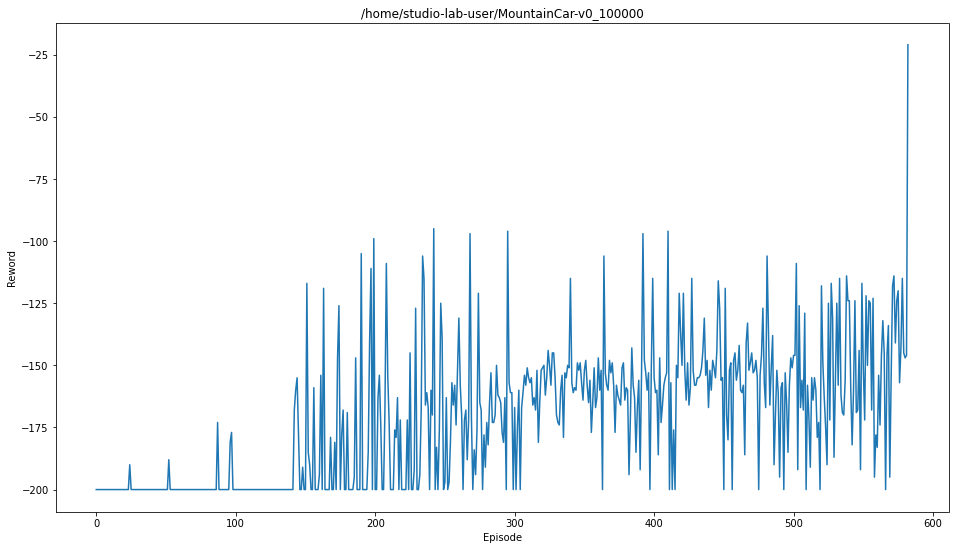

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=[16,9])
plt.plot(list(cb_ep.rewards.keys()), list(cb_ep.rewards.values()))
plt.xlabel("Episode")
plt.ylabel("Reword")
plt.title(title_name)
plt.show()

## 学習済みモデルを用いてテスト
* うまく旗までたどり着くか

In [13]:
# モデルをテスト
dqn.test(env, nb_episodes=nb_episodes, visualize=False, callbacks=[cb_ep])

Testing for 5 episodes ...
Episode 1: reward: -147.000, steps: 147
Episode 2: reward: -143.000, steps: 143
Episode 3: reward: -155.000, steps: 155
Episode 4: reward: -146.000, steps: 146
Episode 5: reward: -150.000, steps: 150


# 番外編!

## モデルの保存
うまく行ったらモデルを保存します。

In [ ]:
save_model_name = "model_test" # @param {type:"string"}

print("保存場所: {0}{1}".format(model_path,save_model_name))

In [ ]:
dqn.model.save(model_path + save_model_name,overwrite=False)

## モデルの読み込み
* 学習済みのモデルをロードしてテストを行います。

### 読み込みモデルの指定
こっそり、100,000ステップ学習済みのモデルを作成してあります。
* model100000 : 100,000 step学習済みのモデル

In [ ]:
load_model_name = "model100000"
print("モデル取得場所: {0}{1}".format(model_path,load_model_name))

### モデルの読み込み

In [ ]:
model=load_model(model_path + load_model_name)

### 読み込んだモデルでテスト

In [ ]:
# テスト動画保存先
env_test = gym.make(env_name)

# エージェントの設定
memory = SequentialMemory(limit=limit_steps, window_length=1)

dqn = DQNAgent(model=model,
               nb_actions=nb_actions,
               memory=memory)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# モデルをテスト
dqn.test(env_test, nb_episodes=nb_episodes, visualize=False, callbacks=[cb_ep])